# Reinforcement Learning Assignment: Easy21 
## From David Silver's [UCL Course on RL](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)

In [1]:
from __future__ import division

from collections import Counter, defaultdict
import itertools

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## 1. Implementation of Easy21

> You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state s (dealer’s first card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns a sample of the next state s′ (which may be terminal if the game is finished) and reward r. We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

In [2]:
def draw_card(draw_black=False):
    if draw_black:
        color = 1
    else:
        color = np.random.choice([-1, 1], size=1, p=[1/3., 2/3.])[0]
    card_val = np.random.randint(1, 11) * color
    return card_val

def step(s, a):
    '''
    s: state, dealer's first card (1-10) and player's sum (1-21)
    a: action: hit(1) or stick(0)
    '''
    s_prime = list(s)[:] # make a copy
    is_terminated = False
    r = 0

    # dealer action
    if s_prime[0] < 17:
        card = draw_card()
        s_prime[0] += card
        if s_prime[0] > 21 or s_prime[0] < 1: # dealer bust
            r = 1
            
    # player hit action
    if a == 1:
        # player draw a card
        card = draw_card()
        s_prime[1] += card

        if s_prime[1] > 21 or s_prime[1] < 1: # player bust
            r = -1
            is_terminated = True
            
    elif a == 0:
        # player stick
        is_terminated = True
        if s_prime[1] > s_prime[0]:
            r = 1
        elif s_prime[1] < s_prime[0]:
            r = -1
        else:
            r = 0
    # In the next state, the player also only see dealer's first card
    s_prime[0] = s[0]
    return tuple(s_prime), r, is_terminated

In [3]:
# Init game
dealer_first_card = draw_card(draw_black=True)
player_first_card = draw_card(draw_black=True)

s0 = (dealer_first_card, player_first_card)
print 'dealer first card, player sum'
print 's0:', s0

dealer first card, player sum
s0: (2, 1)


In [4]:
def policy(s):
    '''A simple policy that always return hit action (1)'''
    a = 1
    return a

# Simulate one episode:
t = 0
is_terminated = False
while not is_terminated:
    a0 = policy(s0) 
    s1, r, is_terminated = step(s0, a0)
    t += 1
    print 's%d:' % t, s1
    s0 = s1

print 'reward: %d' % r 

s1: (2, 5)
s2: (2, 11)
s3: (2, 21)
s4: (2, 24)
reward: -1


In [5]:
def init_game():
    dealer_first_card = draw_card(draw_black=True)
    player_first_card = draw_card(draw_black=True)
    s0 = (dealer_first_card, player_first_card)
    return s0

## 2. Monte-Carlo Control in Easy21

> Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use a time-varying scalar step-size of $\alpha_t = 1/N(s_t,a_t)$ and an ε-greedy exploration strategy with $\epsilon_t = N_0/(N_0 + N(s_t))$, where $N_0 = 100$ is a constant, $N(s)$ is the number of times that state $s$ has been visited, and $N(s,a)$ is the number of times that action a has been selected from state s. Feel free to choose an alternative value for $N_0$, if it helps producing better results. Plot the optimal value function $V^* (s) = max_a Q^* (s, a)$ using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.


### Solution: GLIE Monte-Carlo Control algorithm
- Greedy in the Limit with Infinite Exploration (GLIE)
    + Sample kth episode
    + For each state $S_t$ and action $A_t$ in the episode,    
        update state-action pair counter: $N(S_t, A_t) \leftarrow N(S_t, A_t) + 1$    
        update Q: $Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha_t(G_t - Q(S_t, A_t))$    
    + Improve policy based on new action-value function

In [6]:
Q = defaultdict(lambda: np.zeros(2, dtype=np.float))
N_0 = 100
# state counter N(s)
N_s = Counter()
# state-action pair counter N(s, a)
N_s_a = Counter()

def epsilon_greedy_policy(s, epsilon, Q):
    '''
    Input state s, epsilon, and Q function/table
    return an array (A_probas) of probabilities corresponding to the actions.
    '''
    A_probas = (np.ones(2) / 2) * epsilon # initialize uniformly scaled by epsilon 
    best_action = np.argmax(Q[s]) # find the best action
    A_probas[best_action] += (1.0 - epsilon) 
    return A_probas

In [7]:
# Monte-Carlo Control with epsilon-greedy exploration
n_episodes = 50000

for i in range(n_episodes):
    s0 = init_game()
    t = 0
    is_terminated = False    
    episode = [] # to store (state, action, reward)
    while not is_terminated:
        epsilon = N_0 / (N_0 + N_s[s0])
        A_probas = epsilon_greedy_policy(s0, epsilon, Q)
        a0 = np.random.choice([0, 1], p=A_probas)
        s1, r, is_terminated = step(s0, a0)
        episode.append((s0, a0, r))
        t += 1
        s0 = s1

    if i % 2000 == 0:
        print 'episode %d, reward %d' % (i, r)
    # update counters after each episode
    N_s.update([s for s, _, _ in episode])
    N_s_a.update([(s,a) for s, a, _ in episode])
    # find all (state, action) pairs we've visited in this episode
    sa_pairs = set([(s,a) for s, a, _ in episode])
    
    for s, a in sa_pairs:
        # find the first occurance of the (state, action) pair in the episode
        first_occurence_idx = next(i for i, x in enumerate(episode)
                                   if x[0] == s and x[1] == a)
        # rewards since the first occurance
        G = sum([r for _, _, r in episode[first_occurence_idx:]])
        # update Q
        alpha = 1 / N_s_a[(s, a)]
        Q[s][a] += alpha * (G - Q[s][a])

episode 0, reward -1
episode 2000, reward -1
episode 4000, reward -1
episode 6000, reward -1
episode 8000, reward -1
episode 10000, reward -1
episode 12000, reward -1
episode 14000, reward 1
episode 16000, reward -1
episode 18000, reward 1
episode 20000, reward -1
episode 22000, reward 0
episode 24000, reward 1
episode 26000, reward 1
episode 28000, reward -1
episode 30000, reward -1
episode 32000, reward -1
episode 34000, reward -1
episode 36000, reward 1
episode 38000, reward 1
episode 40000, reward -1
episode 42000, reward 1
episode 44000, reward -1
episode 46000, reward -1
episode 48000, reward 1


In [8]:
# convert Q to value function
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

In [9]:
Q.items()[:5]

[((7, 3), array([-0.53125   ,  0.00848363])),
 ((6, 9), array([-0.09756098,  0.51380796])),
 ((10, 17), array([ 0.48339483, -0.23636364])),
 ((7, 12), array([ 0.23255814,  0.49520081])),
 ((1, 17), array([ 1.        ,  0.02898551]))]

In [10]:
V.items()[:5]

[((7, 3), 0.008483629083324706),
 ((6, 9), 0.51380795671414037),
 ((10, 17), 0.48339483394833949),
 ((7, 12), 0.49520081007125477),
 ((1, 17), 1.0)]

In [11]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z, title)

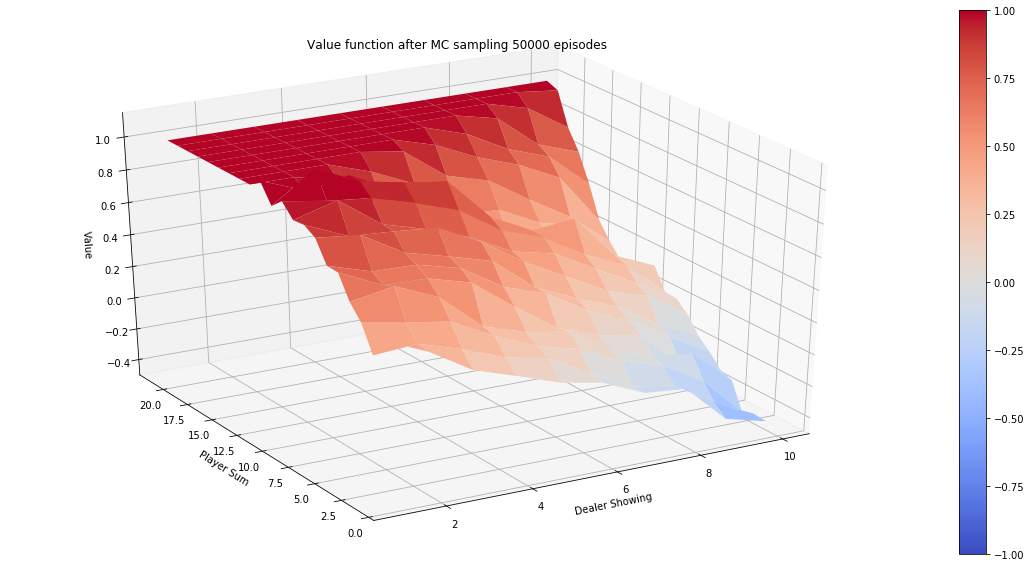

In [12]:
plot_value_function(V, title='Value function after MC sampling %d episodes' % n_episodes)

## 3. TD Learning in Easy21
> Implement Sarsa($\lambda$) in 21s. Initialise the value function to zero. Use the same step-size and exploration schedules as in the previous section. Run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, ..., 1\}$. Stop each run after 1000 episodes and report the mean-squared error $\sum_{s,a}(Q(s, a) - Q^*(s, a))^2$ over all states s and actions a, comparing the true values $Q^*(s,a)$ computed in the previous section with the estimated values $Q(s, a)$ computed by Sarsa. Plot the mean-squared error against $\lambda$. For $\lambda = 0$ and $\lambda = 1$ only, plot the learning curve of mean-squared error against episode number.

### Solution: Sarsa($\lambda$) algorithm 

Psydo-code:

Initialize Q(s, a)    
for each episode:    
&nbsp;&nbsp;Init E(s, a) = 0 for all s and a
&nbsp;&nbsp;for each step in this episode:    
&nbsp;&nbsp;&nbsp;&nbsp;Take action A, observe R, S'    
&nbsp;&nbsp;&nbsp;&nbsp;Choose A' from S' using policy from Q (episilon-greedy)    
&nbsp;&nbsp;&nbsp;&nbsp;$\delta \leftarrow R + \gamma Q(S', A') - Q(S, A)$    
&nbsp;&nbsp;&nbsp;&nbsp;$E(S, A) \leftarrow E(S, A) + 1$    
&nbsp;&nbsp;&nbsp;&nbsp;for all s, a in A(s):    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Update Q and E:    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q(S, A) \leftarrow Q(S, A) + \alpha\delta E(S, A)$    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$E(S, A) \leftarrow \gamma\lambda E(S, A)$    

&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow S'$
&nbsp;&nbsp;&nbsp;&nbsp;$A \leftarrow A'$    


In [13]:
# cache the Q* from Monte-Carlo 
Q_star = Q
del Q
lambdas = np.linspace(0, 1, 5)
all_states = Q_star.keys()
all_actions = [0,1]
print 'Number of possible states:', len(all_states)

Number of possible states: 210


In [14]:
gamma = 1 # discount factor
alpha = 0.05 # learning rate
n_episodes = 20000
# to collect mean-squared errors
MSEs = np.zeros((len(lambdas), n_episodes))

for c, lbda in enumerate(lambdas):
    print 'lambda=%.1f' % lbda
    # init Q to zero
    Q = defaultdict(lambda: np.zeros(2, dtype=np.float))
    # The same step-size and exploration schedules as previous section
    N_0 = 100
    # state counter N(s)
    N_s = Counter()
    # state-action pair counter N(s, a)
    N_s_a = Counter()
    
    for i in range(n_episodes):        
        # initialize E(s, a) = 0
        E = defaultdict(lambda: np.zeros(2, dtype=np.float))
        s0 = init_game()
        t = 0
        is_terminated = False    
        while not is_terminated:
            epsilon = N_0 / (N_0 + N_s[s0])
            A_probas = epsilon_greedy_policy(s0, epsilon, Q)
            a0 = np.random.choice([0, 1], p=A_probas)
            # take action a0, observe s1 and reward
            s1, r, is_terminated = step(s0, a0)

            # update counters after each step
            N_s.update([s0])
            N_s_a.update([(s0, a0)])

            # choose a1 from s1
            A_probas = epsilon_greedy_policy(s1, epsilon, Q)
            a1 = np.random.choice([0, 1], p=A_probas)
            # update TD delta
            delta = r + gamma * Q[s1][a1] - Q[s0][a0] 
            # update E(s, a)
            E[s0][a0] += 1
            for s, a in itertools.product(all_states, all_actions):
                # update Q(s, a) and E(s, a)
                Q[s][a] = Q[s][a] + alpha * delta * E[s][a]
                E[s][a] = gamma * lbda * E[s][a]

            t += 1
            s0 = s1
        
        # compute MSE
        mse = sum((Q_star[s][a] - Q[s][a])**2 for s, a in itertools.product(Q_star.keys(), [0,1])) / ( len(Q_star) * 2)
        MSEs[c, i] = mse
        if i % 2000 == 0:
            print 'episode %d, MSE=%.4f' % (i, mse)

lambda=0.0
episode 0, MSE=0.3386
episode 2000, MSE=0.2500
episode 4000, MSE=0.2017
episode 6000, MSE=0.1693
episode 8000, MSE=0.1537
episode 10000, MSE=0.1542
episode 12000, MSE=0.1599
episode 14000, MSE=0.1918
episode 16000, MSE=0.2367
episode 18000, MSE=0.3155
lambda=0.2
episode 0, MSE=0.3387
episode 2000, MSE=0.2461
episode 4000, MSE=0.1872
episode 6000, MSE=0.1595
episode 8000, MSE=0.1506
episode 10000, MSE=0.1599
episode 12000, MSE=0.1895
episode 14000, MSE=0.2513
episode 16000, MSE=0.3231
episode 18000, MSE=0.3871
lambda=0.5
episode 0, MSE=0.3386
episode 2000, MSE=0.2374
episode 4000, MSE=0.1804
episode 6000, MSE=0.1455
episode 8000, MSE=0.1390
episode 10000, MSE=0.1502
episode 12000, MSE=0.1811
episode 14000, MSE=0.2387
episode 16000, MSE=0.3196
episode 18000, MSE=0.4511
lambda=0.8
episode 0, MSE=0.3384
episode 2000, MSE=0.2279
episode 4000, MSE=0.1692
episode 6000, MSE=0.1351
episode 8000, MSE=0.1318
episode 10000, MSE=0.1573
episode 12000, MSE=0.2260
episode 14000, MSE=0.3022


In [15]:
import seaborn as sns
sns.set_context('talk')

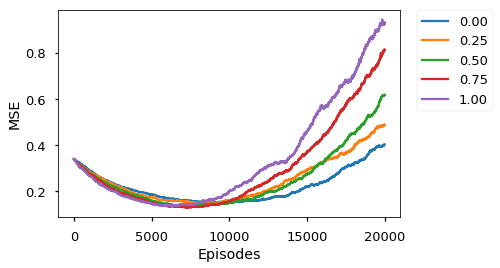

In [16]:
# Plot learning curves across lambdas 
fig, ax = plt.subplots()
for lbda, mses in zip(lambdas, MSEs):
    ax.plot(np.arange(len(mses)), mses, label='%.2f'%lbda)

ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()
plt.show();

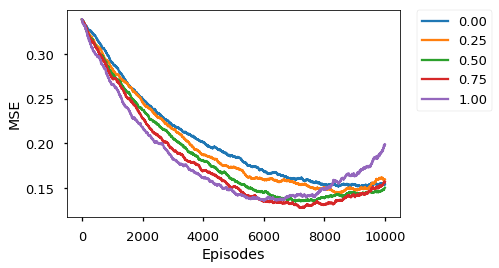

In [17]:
fig, ax = plt.subplots()
for lbda, mses in zip(lambdas, MSEs[:, :10000]):
    ax.plot(np.arange(len(mses)), mses, label='%.2f'%lbda)

ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()
plt.show();

## 4. Linear Function Approximation in Easy21

We now consider a simple value function approximator using coarse coding. Use a binary feature vector with $3 * 6 * 2 = 36$ features. Each binary feature has a value of 1 if (s, a) lies within the cuboid of state-space corresponding to that feature, and the action corresponding to that feature. The cuboids have the following overlapping intervals:


- dealer(s) = {[1, 4], [4, 7], [7, 10]}
- player(s) = {[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]}
- a = {hit, stick}

Use linear value function approximation: $Q(s, a) = \phi(s, a)^\intercal \theta$

Use a constant exploration of $\epsilon = 0.05$ and a constant step-size of 0.01. Plot the mean-squared error against $\lambda$.

## Solution: Sarsa($\lambda$) with linear function approximation

Psydo-code:

Initialize $\boldsymbol{\theta}$ arbitrarily    
for each episode:    
&nbsp;&nbsp;Init $\mathbf{E} = 0$
&nbsp;&nbsp;for each step in this episode:    
&nbsp;&nbsp;&nbsp;&nbsp;Take action A, observe R, S'    
&nbsp;&nbsp;&nbsp;&nbsp;Choose A' from S' using policy from Q (episilon-greedy)    
&nbsp;&nbsp;&nbsp;&nbsp;$\delta \leftarrow R + \gamma \boldsymbol{\theta}^\intercal \cdot \phi(S', A') - \boldsymbol{\theta}^\intercal \cdot \phi(S, A)$    
&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{E} \leftarrow \gamma \lambda \mathbf{E} + \phi(S, A)$    
&nbsp;&nbsp;&nbsp;&nbsp;$\boldsymbol{\theta} \leftarrow \alpha \delta \boldsymbol{\theta} $
&nbsp;&nbsp;&nbsp;&nbsp;

&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow S'$
&nbsp;&nbsp;&nbsp;&nbsp;$A \leftarrow A'$    


In [18]:
from sklearn import metrics

def extract_feature_vector(state, action):
    feature = np.ones([3, 6, 2])
    x, y = state
    feature[:, :, 1 - action] = 0
    x_space = [[1, 4], [4, 7], [7, 10]]
    y_space = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
    for i in range(len(x_space)):
        if x < x_space[i][0] or x > x_space[i][1]:
            feature[i, :, :] = 0
    for i in range(len(y_space)):
        if y < y_space[i][0] or y > y_space[i][1]:
            feature[:, i, :] = 0
    return feature.flatten()

def epsilon_greedy_policy_function(s, epsilon, theta):
    '''
    Input state s, epsilon, and the weights theta for evaluating of Q
    return an array (A_probas) of probabilities corresponding to the actions.
    '''
    A_probas = (np.ones(2) / 2) * epsilon # initialize uniformly scaled by epsilon 
    # find the best action from the function
    x0 = extract_feature_vector(s, 0)
    x1 = extract_feature_vector(s, 1)
    X = np.array([x0, x1])
    best_action = np.argmax(np.dot(X, theta))
    A_probas[best_action] += (1.0 - epsilon) 
    return A_probas    

In [19]:
epislon = 0.05
alpha = 0.01
gamma = 1.
lambdas = np.linspace(0, 1, 5)

n_episodes = 10000
# to collect mean-squared errors
MSEs = np.zeros((len(lambdas), n_episodes))

# convert Q_star table to matrix/vector form to calculate MSE
X_star = np.zeros((len(Q_star)*2, 36))
y_star = np.zeros(len(Q_star)*2)

c = 0
for s, values in Q_star.items():
    x0 = extract_feature_vector(s, 0) 
    x1 = extract_feature_vector(s, 1)
    X_star[c] = x0
    X_star[c+1] = x1
    y_star[c:c+2] = values
    c += 2

In [20]:
np.random.seed(42)
for j, lbda in enumerate(lambdas):
    print 'lambda=%.1f' % lbda  
#     theta = np.random.randn(36) # weights for the linear model
    theta = np.zeros(36) # weights for the linear model
    for i in range(n_episodes):        
        s0 = init_game()
        t = 0
        is_terminated = False    
        # initialize E, eligibility trace to 0's
        E = np.zeros(36)
        while not is_terminated:
            A_probas = epsilon_greedy_policy_function(s0, epsilon, theta)
            a0 = np.random.choice([0, 1], p=A_probas)
            # take action a0, observe s1 and reward
            s1, r, is_terminated = step(s0, a0)
            
            x0 = extract_feature_vector(s0, a0)
            q0 = np.dot(x0.T, theta)
            if is_terminated:
                td_target = r
                delta = td_target - q0
                a1 = 0
            else:
                # choose a1 from s1
                A_probas = epsilon_greedy_policy_function(s1, epsilon, theta)
                a1 = np.random.choice([0, 1], p=A_probas)
                x1 = extract_feature_vector(s1, a1)
                q1 = np.dot(x1.T, theta)
                td_target = r + gamma * q1
                delta = td_target - q0
                
            # update E(s, a)
            E = gamma * lbda * E + x0
            # update theta
            theta = theta + alpha * delta * E
            
            t += 1
            s0 = s1
            
        # compute MSE
        mse = metrics.mean_squared_error(y_star, np.dot(X_star, theta))
        MSEs[j, i] = mse
        if i % 1000 == 0:
            print 'episode %d, MSE=%.4f' % (i, mse)

lambda=0.0
episode 0, MSE=0.3372
episode 1000, MSE=0.1366
episode 2000, MSE=0.1028
episode 3000, MSE=0.0861
episode 4000, MSE=0.0712
episode 5000, MSE=0.0618
episode 6000, MSE=0.0616
episode 7000, MSE=0.0599
episode 8000, MSE=0.0580
episode 9000, MSE=0.0598
lambda=0.2
episode 0, MSE=0.3392
episode 1000, MSE=0.0834
episode 2000, MSE=0.0745
episode 3000, MSE=0.0646
episode 4000, MSE=0.0583
episode 5000, MSE=0.0601
episode 6000, MSE=0.0574
episode 7000, MSE=0.0588
episode 8000, MSE=0.0661
episode 9000, MSE=0.0635
lambda=0.5
episode 0, MSE=0.3392
episode 1000, MSE=0.0900
episode 2000, MSE=0.0719
episode 3000, MSE=0.0666
episode 4000, MSE=0.0655
episode 5000, MSE=0.0607
episode 6000, MSE=0.0591
episode 7000, MSE=0.0681
episode 8000, MSE=0.0593
episode 9000, MSE=0.0609
lambda=0.8
episode 0, MSE=0.3394
episode 1000, MSE=0.0952
episode 2000, MSE=0.0770
episode 3000, MSE=0.0729
episode 4000, MSE=0.0692
episode 5000, MSE=0.0659
episode 6000, MSE=0.0685
episode 7000, MSE=0.0623
episode 8000, MSE=

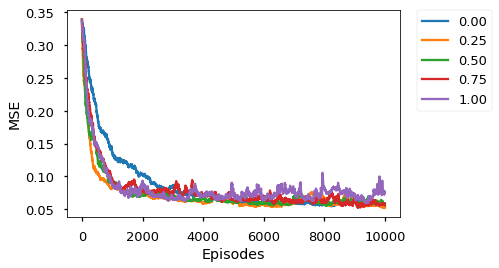

In [21]:
# Plot learning curves across lambdas 
fig, ax = plt.subplots()
for lbda, mses in zip(lambdas, MSEs):
    ax.plot(np.arange(len(mses)), mses, label='%.2f'%lbda)

ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()
plt.show();

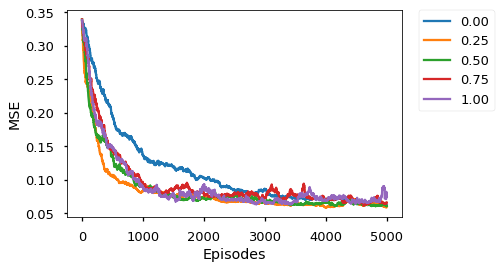

In [22]:
fig, ax = plt.subplots()
for lbda, mses in zip(lambdas, MSEs[:, :5000]):
    ax.plot(np.arange(len(mses)), mses, label='%.2f'%lbda)

ax.set_xlabel('Episodes')
ax.set_ylabel('MSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()
plt.show();